# WIRELESS SENSOR NETWORK - DATA ANALYZER
#### Notebook not intended for final product

# LIBRARIES

In [89]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import IPython.display
from datetime import datetime
from statistics import mean
#NP = DF.to_numpy()
#DF = pd.DataFrame(NP)

# DATA SELCTION
Incoming data has two columns: UNIXTIME and GASDATA

In [96]:
# Set Working Directory
user      = 'adria'
subfolder = 'V 1.2.3B'
#file      = '2020-03-04--08EDITED.csv'
#file      = '2020-03-03--00.csv'
file      = 'C-2020-03-04.csv'


os.chdir('C:\\Users\\'+str(user)+'\\Desktop\\Repository\\WirelessSensorNetwork\\Data\\'
         + str(subfolder))
os.getcwd()
data = pd.read_csv(file)
data.head()

,UnixTime,GasData
0,1583294401,409.0
1,1583294402,409.0
2,1583294403,410.0
3,1583294404,410.0
4,1583294405,410.0


# IMPORT DATA
Prime the data for filtering by turning UNIXTIME and GASDATA columns to floats and by adding DATETIME, REALDATA, and INDEX columns

In [97]:
def importData(data):
    #Create columns
    UnixTime = np.array(data['UnixTime'])
    GasData  = np.array(data['GasData'])
    RealData = np.ones((len(UnixTime), 1))
    Index    = np.arange(0, len(UnixTime))
    rawAllDataDF = pd.DataFrame(np.column_stack((UnixTime, GasData, RealData, Index)))
    rawAllDataDF['DateTime'] = pd.to_datetime(rawAllDataDF.iloc[:,0], unit = 's')
    rawAllDataDF.columns     = ['UnixTime', 'GasData', 'RealData', 'Index', 'DateTime']

    #Drop duplicates and change datatypes
    rawAllDataDF = rawAllDataDF.drop_duplicates(subset='UnixTime', keep='first')
    rawAllDataDF.UnixTime = rawAllDataDF.UnixTime.astype(int)
    rawAllDataDF.RealData = rawAllDataDF.RealData.astype(int)
    rawAllDataDF.Index    = rawAllDataDF.Index.astype(int)
    
    #Create dataframe
    rawAllDataNP = rawAllDataDF.to_numpy()
    return rawAllDataDF, rawAllDataNP
rawAllDataDF, rawAllDataNP = importData(data)
rawAllDataDF.head()

,UnixTime,GasData,RealData,Index,DateTime
0,1583294401,409.0,1,0,2020-03-04 04:00:01
1,1583294402,409.0,1,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2,2020-03-04 04:00:03
3,1583294404,410.0,1,3,2020-03-04 04:00:04
4,1583294405,410.0,1,4,2020-03-04 04:00:05


# IMPORT CHECK
Ensure that the datatypes are correct. <br>
UNIXTIME: Int <br>
GASDATA:  Float <br>
REALDATA: Int <br>
INDEX:    Int <br>
DATETIME: Timestamp <br>
Determines extreme values within the data set <br>


In [98]:
def importCheck(rawAllDataNP, rawAllDataDF):
    #Print datatypes
    print('|----------DATA CHECKER ----------|')
    print('UNIXTIME:', rawAllDataNP[0][0], type(rawAllDataNP[0][0]))
    print('GASDATA :', rawAllDataNP[0][1], type(rawAllDataNP[0][1]))
    print('REALDATA:', rawAllDataNP[0][2], type(rawAllDataNP[0][2]))
    print('INDEX:   ', rawAllDataNP[0][3], type(rawAllDataNP[0][3]))    
    print('DATETIME:', rawAllDataNP[0][4], type(rawAllDataNP[0][4]), "\n")
    #Print extreme values
    print('Data Amt:', len(rawAllDataNP[:]))
    print('Gas  Min:', min(rawAllDataNP[:,1]))
    print('Gas  Max:', max(rawAllDataNP[:,1]))
    print('Unix Min:', min(rawAllDataNP[:,0]))
    print('Unix Min:', max(rawAllDataNP[:,0]))
       
importCheck(rawAllDataNP, rawAllDataDF)

|----------DATA CHECKER ----------|
UNIXTIME: 1583294401 <class 'int'>
GASDATA : 409.0 <class 'float'>
REALDATA: 1 <class 'int'>
INDEX:    0 <class 'int'>
DATETIME: 2020-03-04 04:00:01 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 

Data Amt: 10800
Gas  Min: 406.0
Gas  Max: 418.0
Unix Min: 1583294401
Unix Min: 1583305200


# FILTER DATA
Determine the indeces containing bad data. <br>
Create new PandasFrame filAllData <br>

In [99]:
def dataFilterWhere(rawAllDataNP):
    #Determine indices
    gasZerosIndices  = np.where( rawAllDataNP[:,1] == 0)
    gasLowIndices    = np.where((rawAllDataNP[:,1] <= 350) & (rawAllDataNP[:,1] > 0))
    gasHighIndices   = np.where( rawAllDataNP[:,1] >= 5000) 
    gasNegIndices    = np.where( rawAllDataNP[:,1] < 0 )
    timeZerosIndices = np.where( rawAllDataNP[:,0] == 0)
    timeLowIndices   = np.where((rawAllDataNP[:,0] <= 1576594500) & (rawAllDataNP[:,0] > 0))
    timeHighIndices  = np.where( rawAllDataNP[:,0] >= 2000000000)                            
    timeNegIndices   = np.where( rawAllDataNP[:,0] < 0)

    fullRemovalIndices = np.concatenate((
        gasZerosIndices, gasLowIndices, gasHighIndices, gasNegIndices,
        timeZerosIndices,timeLowIndices,timeHighIndices,timeNegIndices), axis = None)
    
    #Print removal info
    print('|----------DATA REMOVED----------|')
    print('Gas  Zeros: ', len(gasZerosIndices[0]))
    print('Gas   Lows: ', len(gasLowIndices[0]))
    print('Gas  Highs: ', len(gasHighIndices[0]))
    print('Gas   Negs: ', len(gasNegIndices[0]))
    print('Time Zeros: ', len(timeZerosIndices[0]))
    print('Time  Lows: ', len(timeLowIndices[0]))
    print('Time Highs: ', len(timeHighIndices[0]))
    print('Time  Negs: ', len(timeNegIndices[0]))
    print('Total Remd: ', (len(gasZerosIndices[0]) + len(gasLowIndices[0]) + 
        len(gasHighIndices [0]) + len(gasNegIndices[0]) + len(timeZerosIndices[0]) + 
        len(timeLowIndices[0]) + len(timeHighIndices[0]) + len(timeNegIndices[0])))
    print('Total Remd: ', len(fullRemovalIndices))

    #Create new dataframe
    filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]
    filAllDataNP = filAllDataDF.to_numpy()
    return filAllDataNP, filAllDataDF, fullRemovalIndices
    
filAllDataNP, filAllDataDF, fullRemovalIndices = dataFilterWhere(rawAllDataNP)

|----------DATA REMOVED----------|
Gas  Zeros:  0
Gas   Lows:  0
Gas  Highs:  0
Gas   Negs:  0
Time Zeros:  0
Time  Lows:  0
Time Highs:  0
Time  Negs:  0
Total Remd:  0
Total Remd:  0


# FRAME SELECTION
Allows user to select viewing frame for analysis purposes. <br>
Determines theoretical length of data assuming perfect collection. <br>
Compares theoretical length to real length. <br>

In [100]:
def windowSelect(filAllDataNP, leftFrame, rightFrame):
    #Determine validity of selected frame
    leftFrameIndex   = np.where( filAllDataNP[:,0] == leftFrame)[0]
    rightFrameIndex  = (np.where( filAllDataNP[:,0] == rightFrame))[0]
    if leftFrameIndex.size == 1 and rightFrameIndex.size == 1 :
        
        #Create dataframe of fraAllData   
        fraAllDataDF = filAllDataDF.iloc[leftFrameIndex[0]:rightFrameIndex[0]+1,:]
        fraAllDataNP = fraAllDataDF.to_numpy()

        #Plot selected window frame
        plt.close('all')
        x  = fraAllDataNP[:,4]  
        y  = fraAllDataNP[:,1]
        plt.plot(x, y, "ro")
        plt.plot(x, y, "k-")
        plt.grid()

    else:
            print('Invalid selection')
    return fraAllDataNP, fraAllDataDF


,UnixTime,GasData,RealData,Index,DateTime
0,1583294401,409.0,1,0,2020-03-04 04:00:01
1,1583294402,409.0,1,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2,2020-03-04 04:00:03
3,1583294404,410.0,1,3,2020-03-04 04:00:04
4,1583294405,410.0,1,4,2020-03-04 04:00:05


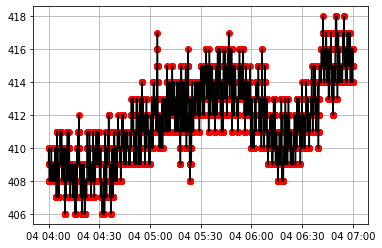

In [104]:
#Select frame limits
#left  = datetime(2020, 3, 4, 8, 0, 10)
#right = datetime(2020, 3, 4, 8, 0, 40)
#leftFrame  = int(datetime.timestamp(left) - 25200.0)
#rightFrame = int(datetime.timestamp(right) - 25200.0)

leftFrame = filAllDataNP[0][0]  #Both indexes are inclusive
rightFrame = filAllDataNP[-1][0] #Both indexes are inclusive

fraAllDataNP, fraAllDataDF = windowSelect(filAllDataNP, leftFrame, rightFrame)
fraAllDataDF.head()

# DETERMINE MISSING DATA
Missing datapoints due to filtering of bad data, node shutdowns, module malfunctions

In [105]:
def missingDataDeterminer(data):
    leftFrameUnix  = data[0][0]
    rightFrameUnix = data[-1][0] 
    spanFrameUnix  = np.arange(leftFrameUnix, rightFrameUnix+1)
    missingData    = np.array([])

    s = set(data[:,0])
    for i in range(0, len(spanFrameUnix)):
        if spanFrameUnix[i] not in s:
            missingData = np.append(missingData, spanFrameUnix[i]) 
    print(len(missingData), "missing points from", [name for name in globals() if globals()   
        [name] is data])
    return missingData

rawMissingData = missingDataDeterminer(rawAllDataNP)
filMissingData = missingDataDeterminer(filAllDataNP)
fraMissingData = missingDataDeterminer(fraAllDataNP)

0 missing points from ['rawAllDataNP']
0 missing points from ['filAllDataNP']
0 missing points from ['fraAllDataNP']


In [106]:
#Clear Space
%reset_selective data, rawAllDataDF, rawAllDataNP
#filAllDataDF = rawAllDataDF[~rawAllDataDF.index.isin(fullRemovalIndices)]

Nothing done.


# ESTIMATE DATA
If there is a missing data point in between two real data, make an estimation

In [107]:
def estimateData(missingFra):  
    misGas  = np.array([])
    misReal = np.zeros((len(missingFra)))
    missingFra = missingFra.astype(int) 

    #Perform estimation for every missing index
    for j in missingFra:
        left  = j - 1
        right = j + 1
        #Check that bordering points exist
        if((left in filAllDataNP[:,0])&(right in filAllDataNP[:,0]))==True:
            leftIndex  = np.where(filAllDataNP[:,0] == left)
            rightIndex = np.where(filAllDataNP[:,0] == right)
            leftData   = filAllDataNP[leftIndex[0][0]][1]
            rightData  = filAllDataNP[rightIndex[0][0]][1]
            #Check that bordering points are close in value
            if (abs(leftData - rightData) <= 1) :
                midData = (leftData + rightData) / 2
                misGas  = np.append(misGas, midData)
            else:
                misGas  = np.append(misGas, None)
        else:
            misGas  = np.append(misGas, None)
    print(missingFra)
    print(misGas)
    print(misReal)

    #Combine Estimated Data with Real Data
    estUnix = np.concatenate((fraAllDataNP[:,0], missingFra), axis = 0)    
    estGas  = np.concatenate((fraAllDataNP[:,1], misGas),     axis = 0)
    estReal = np.concatenate((fraAllDataNP[:,2], misReal),    axis = 0)
    df = pd.DataFrame(np.column_stack((estUnix, estGas, estReal)))
    df.columns     = ['UnixTime', 'GasData', 'RealData']

    dfs = df.sort_values(by = ['UnixTime'], inplace = False)
    dfs = dfs.reset_index(drop=True)
    dfs['DateTime'] = pd.to_datetime(dfs.iloc[:,0], unit = 's')
    dfs.GasData = dfs.GasData.astype(float)
    dfs.RealData = dfs.RealData.astype(int)

    #Drop Zeros and Null
    #dfs = dfs[dfs.GasData != 0.0]
    #dfs = dfs[dfs.GasData.notnull()]

    estAllDataDF = dfs
    estAllDataNP = estAllDataDF.to_numpy()
    nanCounter = estAllDataDF.GasData.isna().sum()
    return estAllDataNP, estAllDataDF, nanCounter

In [108]:
estAllDataNP, estAllDataDF, nanCounter = estimateData(fraMissingData)
estAllDataDF.head()

[]
[]
[]


,UnixTime,GasData,RealData,DateTime
0,1583294401,409.0,1,2020-03-04 04:00:01
1,1583294402,409.0,1,2020-03-04 04:00:02
2,1583294403,410.0,1,2020-03-04 04:00:03
3,1583294404,410.0,1,2020-03-04 04:00:04
4,1583294405,410.0,1,2020-03-04 04:00:05


In [109]:
print(len(filAllDataNP))
print(len(fraAllDataNP))
print(len(estAllDataNP))

10800
10800
10800


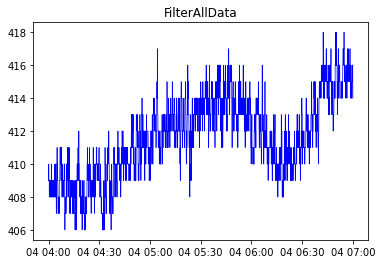

In [110]:
#FilterAllData
#plt.plot(filAllDataNP[:,4], filAllDataNP[:,1], 'ro')
plt.plot(filAllDataNP[:,4], filAllDataNP[:,1], 'b', linewidth = 0.7)
plt.title('FilterAllData')
plt.show()

In [74]:
#FrameAllData
#plt.plot(fraAllDataNP[:,4], fraAllDataNP[:,1], 'ro')
#plt.plot(fraAllDataNP[:,4], fraAllDataNP[:,1], 'k-')
#plt.title('FrameAllData')
#plt.show()

In [73]:
#EstimateAllData
#plt.plot(estAllDataNP[:,3], estAllDataNP[:,1], 'ro')
#plt.plot(estAllDataNP[:,3], estAllDataNP[:,1], 'k')
#plt.title('EstAllData')
#plt.show()